# Data analysis

This file has two parts:
- Analysis of demand time-series
- Analysis of weather data


In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
pd.plotting.register_matplotlib_converters()

from google.colab import drive
drive.mount('/content/gdrive', force_remount=False)
%cd '/content/gdrive/MyDrive/ECSE_552/Project'

Mounted at /content/gdrive
/content/gdrive/.shortcut-targets-by-id/1t5tkKNNd877WyocXM37ISjMi0QHU1xjW/Project


##**PART1: Analysis of demand time-series**

Analyzing hourly demand data for 2017-2020. With code from: https://machinelearningmastery.com/time-series-data-visualization-with-python/

In [ ]:
df = pd.read_csv('data/raw_data/demand/ON_demand_17-20.csv', header=0, index_col=0, parse_dates=True, squeeze=True)
df.drop(columns=['Market Demand'], inplace=True)
df.head()


,Hour,Ontario Demand
Date,,
2017-01-01,1,13522
2017-01-01,2,13117
2017-01-01,3,12816
2017-01-01,4,12605
2017-01-01,5,12563


**Plot load from 2017-2020**

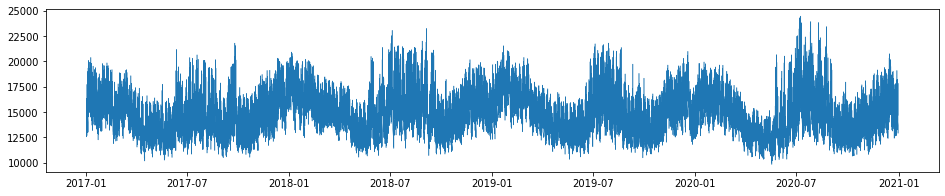

In [ ]:
plt.figure(figsize=(16,3))
plt.plot('Ontario Demand', data=df, linewidth=0.5)
plt.show()

**Compare the four years**

<Figure size 864x864 with 0 Axes>

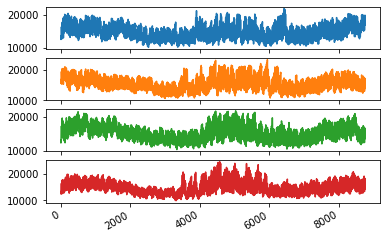

In [ ]:
#drop last day of 2020 (leap year) to achieve same length sequences
df2 = df.iloc[:-24]

groups = df2.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group['Ontario Demand'].values

plt.figure(figsize=(12,12))
years.plot(subplots=True, legend=False)
plt.show()

We can see repeating patterns between the years.

**Histogram**

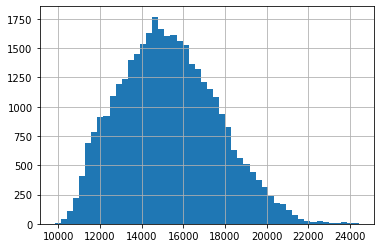

In [ ]:
df['Ontario Demand'].hist(bins=50)
plt.show()

**Box & Whisker plots by year**

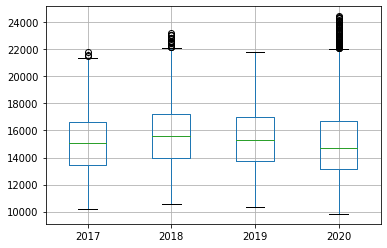

In [ ]:
# again, drop last day of 2020 (leap year)
df2 = df.iloc[:-24]
groups = df2.groupby(pd.Grouper(freq='A'))
years = pd.DataFrame()
for name, group in groups:
    years[name.year] = group['Ontario Demand'].values

years.boxplot()
plt.show()

Different years seem to be fairly comparable.

**Box & Whisker plots by month**

/usr/local/lib/python3.7/dist-packages/numpy/core/_asarray.py:83: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  return array(a, dtype, copy=False, order=order)


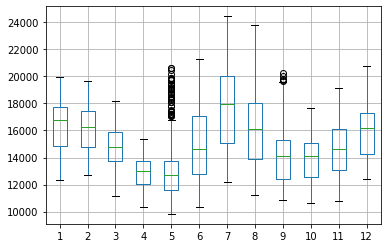

In [ ]:
# pick one year
one_year = df['2020']
groups = one_year['Ontario Demand'].groupby(pd.Grouper(freq='M'))
months = pd.concat([pd.DataFrame(x[1].values) for x in groups], axis=1)
months = pd.DataFrame(months)
months.columns = range(1,13)
months.boxplot()
plt.show()

Figure shows yearly flunctuations in demand, with peaks in summer and winter. Some outliers in Mai and September, probably those months are prone to 'extremes'.

**Autocorrelation plots**

Computes the Pearson-correlation between the series and its lags.

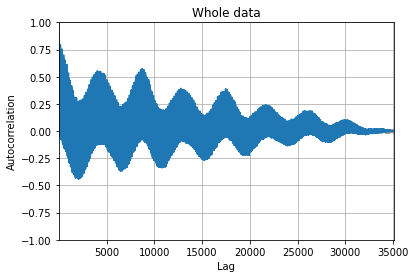

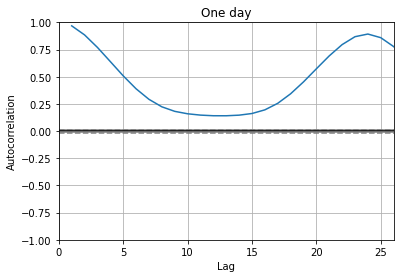

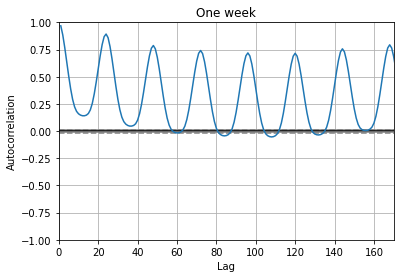

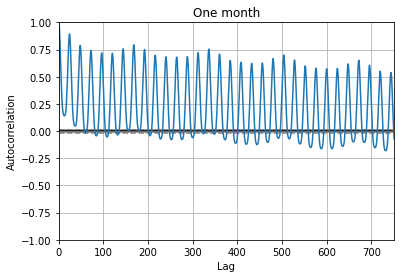

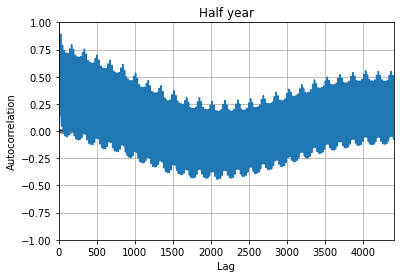

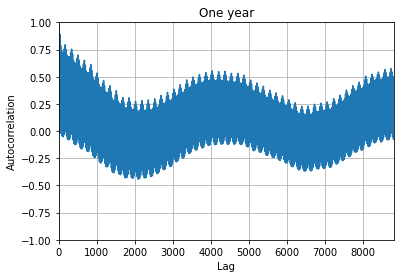

In [ ]:
pd.plotting.autocorrelation_plot(df['Ontario Demand'])  # whole time-series
plt.title('Whole data')
plt.show()

pd.plotting.autocorrelation_plot(df['Ontario Demand']).set_xlim([0, 26])  # one day
plt.title('One day')
plt.show()

pd.plotting.autocorrelation_plot(df['Ontario Demand']).set_xlim([0, 170])  # one week
plt.title('One week')
plt.show()

pd.plotting.autocorrelation_plot(df['Ontario Demand']).set_xlim([0, 750])  # one month
plt.title('One month')
plt.show()

pd.plotting.autocorrelation_plot(df['Ontario Demand']).set_xlim([0, 4400])  # half year
plt.title('Half year')
plt.show()

pd.plotting.autocorrelation_plot(df['Ontario Demand']).set_xlim([0, 8800])  # one year
plt.title('One year')
plt.show()

Interpretation: Strongest overall correlation is measured between a time-step and its previous time-step (i.e. the previous hour), this justifies the usage of a persistance model as baseline.

There is several other correlations, e.g:
- day vs. night (negatively)
- day vs. next day (positively)
- now vs. in one week (positively)
- now vs. half year (positively)

**Periodicity for electricity demand**

In [ ]:
df = pd.read_csv('data/raw_data/demand/ON_demand_17-20.csv', header=0, parse_dates=True, squeeze=True)
df.drop(columns=['Market Demand'], inplace=True)
df.head(25)

,Date,Hour,Ontario Demand
0,2017-01-01,1,13522
1,2017-01-01,2,13117
2,2017-01-01,3,12816
3,2017-01-01,4,12605
4,2017-01-01,5,12563
5,2017-01-01,6,12544
6,2017-01-01,7,12758
7,2017-01-01,8,13065
8,2017-01-01,9,13367
9,2017-01-01,10,13644


In [ ]:
datetime = pd.to_datetime(df['Date']) + pd.to_timedelta(df['Hour'], unit='h')

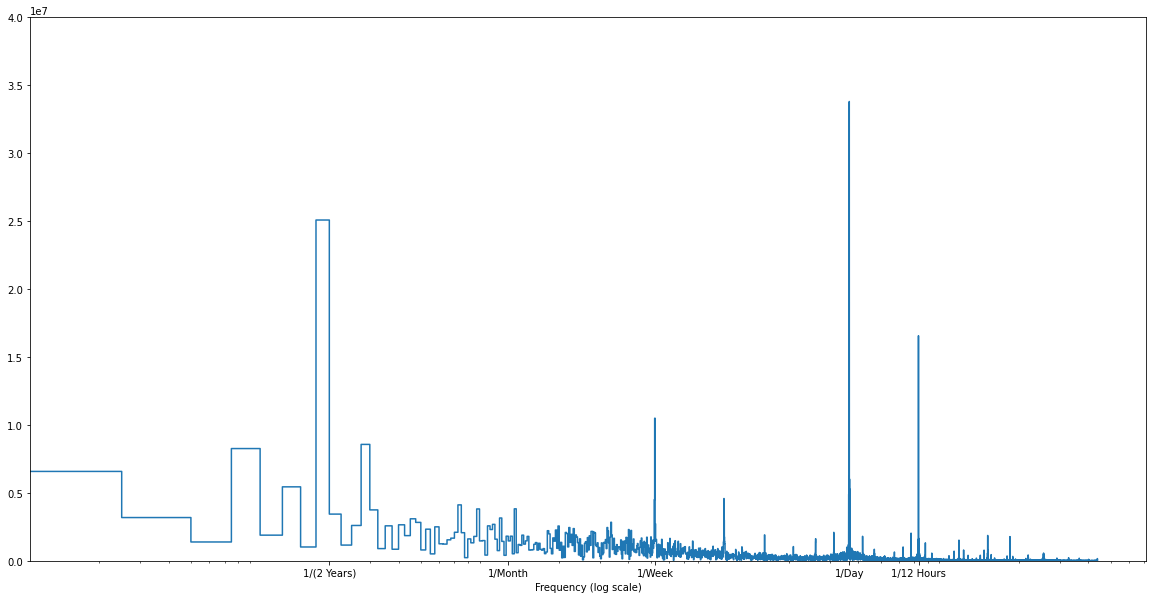

In [ ]:
import tensorflow as tf
fft = tf.signal.rfft(df['Ontario Demand'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df['Ontario Demand'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.figure(figsize=(20,10))
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 40000000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1/12*24, 12, 52.129, 365.2524, 365.2524*2], labels=['1/(2 Years)', '1/Month', '1/Week', '1/Day', '1/12 Hours'])
_ = plt.xlabel('Frequency (log scale)')

Greatest correlations happen at frequencies of 2 years, 1 week, 1 day, and 12 hours. While 1 day and 1 week frequencies are natural, 2 years (instead of 1 year) and 12 hours frequencies are unexpected. So the following analysis is to verify the periodicity for these two frequencies.

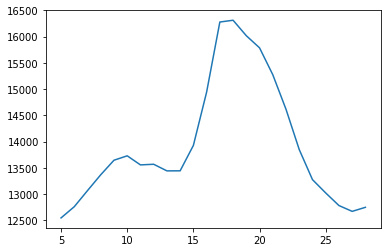

In [ ]:
df['Ontario Demand'][5:29].plot()
plt.show()

We can notice that the energy demand doesn't go all the way up from 5 hrs to 16 hours. Instead, it reaches a local maximum at about 10 hrs, and then drop slightly from 10 hrs to 14 hrs. This is probably why the model considers a 12 hours period is also important

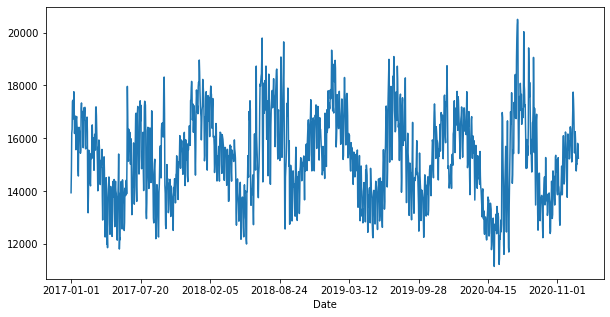

In [ ]:
df_daily_mean = df.groupby(by='Date').mean()
fig = plt.figure(figsize=(10,5))
df_daily_mean['Ontario Demand'].plot()
plt.show()

In [ ]:
df_weather = pd.read_csv('/content/gdrive/MyDrive/ECSE_552/Project/data/ON_weather_17-20.csv', header=0, parse_dates=True, squeeze=True)

In [ ]:
df_weather.head()

,Unnamed: 0,toronto_Temp (C),hamilton_Temp (C),ottawa_Temp (C),kitchener_Temp (C),london_Temp (C),windsor_Temp (C),Weighted Average Temp (C)
0,0,0.5,-0.2,-8.4,-1.0,-0.9,-0.1,-0.797279
1,1,0.8,-0.6,-8.0,-1.3,-1.4,-0.8,-0.650239
2,2,0.6,-0.6,-7.5,-1.5,-2.0,-1.9,-0.799388
3,3,1.0,-0.9,-6.9,-1.9,-2.1,-2.6,-0.541289
4,4,1.0,-1.2,-6.2,-2.9,-2.5,-3.3,-0.582452


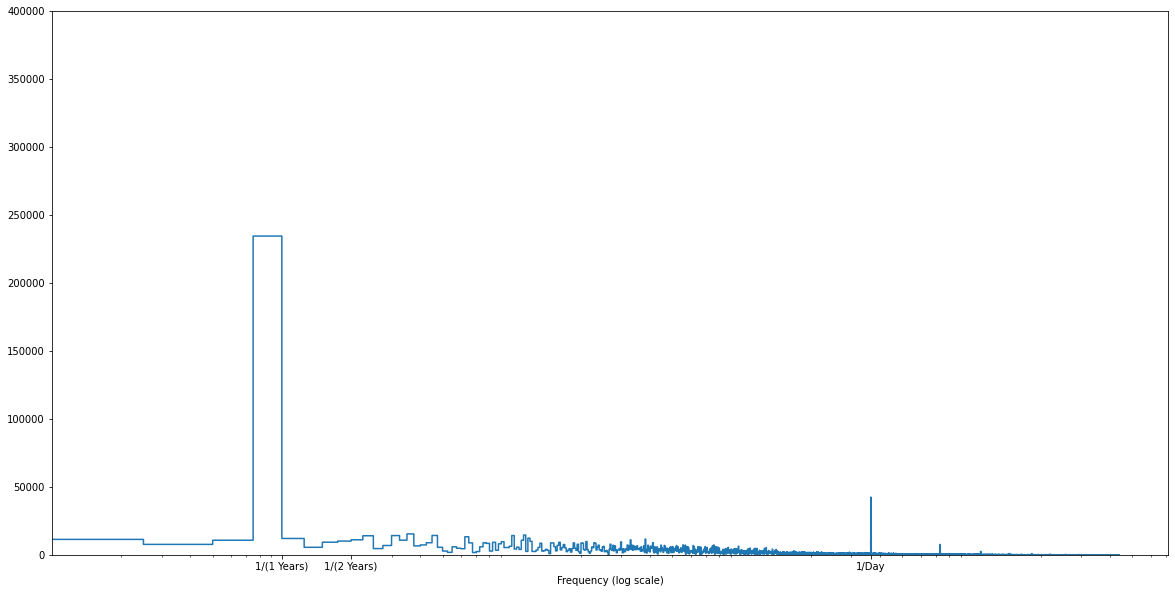

In [ ]:
import tensorflow as tf
fft = tf.signal.rfft(df_weather['Weighted Average Temp (C)'])
f_per_dataset = np.arange(0, len(fft))

n_samples_h = len(df_weather['Weighted Average Temp (C)'])
hours_per_year = 24*365.2524
years_per_dataset = n_samples_h/(hours_per_year)

f_per_year = f_per_dataset/years_per_dataset
plt.figure(figsize=(20,10))
plt.step(f_per_year, np.abs(fft))
plt.xscale('log')
plt.ylim(0, 400000)
plt.xlim([0.1, max(plt.xlim())])
plt.xticks([1, 1/12*24, 365.2524], labels=['1/(1 Years)', '1/(2 Years)', '1/Day'])
_ = plt.xlabel('Frequency (log scale)')

**Time-differencing**

To convert the non-stationary time-series into a stationary time-series, let's time-difference the demand with lag=1.

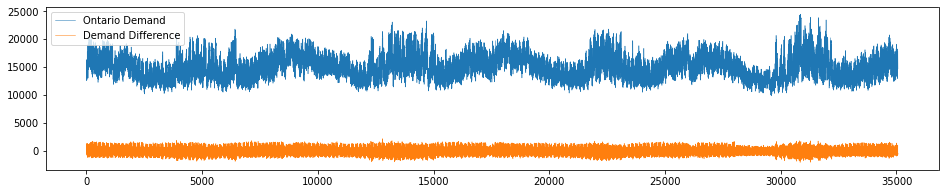

In [ ]:
# Read in dataset without date as index (for plotting purposes)
df = pd.read_csv('data/raw_data/demand/ON_demand_17-20.csv')
df.drop(columns=['Market Demand'], inplace=True)

# Time differencing
diff = df["Ontario Demand"].diff(periods=1)
df['Demand Difference'] = diff.values

# Plot entire time-series
plt.figure(figsize=(16,3))
plt.plot(df["Ontario Demand"], linewidth=0.5, label = "Ontario Demand")
plt.plot(df['Demand Difference'], linewidth=0.5, label = "Demand Difference")
plt.legend()
plt.show()

We can see that time-differencing with lag=1 removes seasonal patterns (e.g. summer vs. fall)

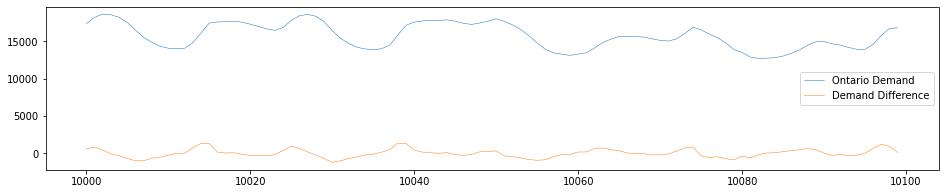

In [ ]:
# Plot random 100 hours of the time-series
df = df.iloc[10000:10100]
plt.figure(figsize=(16,3))
plt.plot(df["Ontario Demand"], linewidth=0.5, label = "Ontario Demand")
plt.plot(df['Demand Difference'], linewidth=0.5, label = "Demand Difference")
plt.legend()
plt.show()

Here we can see that daily patterns remain visible in the time-differences series.

**Log-transform**
(to alleviate exponential effects in the target variable)

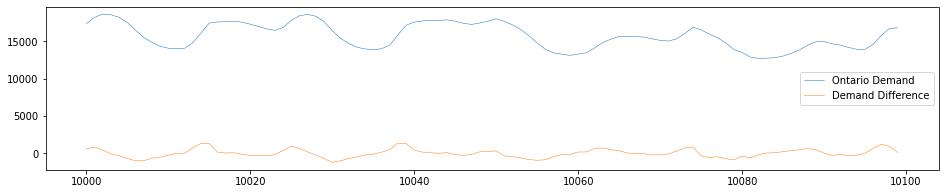

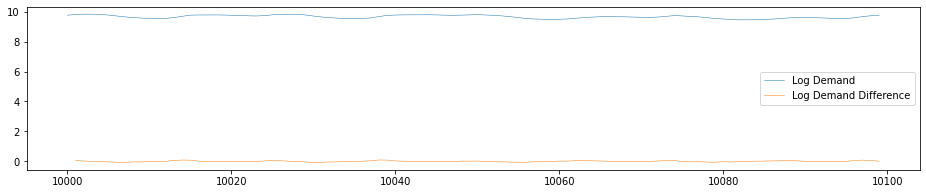

In [ ]:
df['log demand'] = np.log(df['Ontario Demand'])

# Time differencing on log demand
diff = df["log demand"].diff(periods=1)
df['log demand difference'] = diff.values

# Plot time-series
plt.figure(figsize=(16,3))
plt.plot(df["Ontario Demand"], linewidth=0.5, label = "Ontario Demand")
plt.plot(df['Demand Difference'], linewidth=0.5, label = "Demand Difference")
plt.legend()
plt.show()

plt.figure(figsize=(16,3))
plt.plot(df['log demand'], linewidth=0.5, label = "Log Demand")
plt.plot(df['log demand difference'], linewidth=0.5, label = "Log Demand Difference")
plt.legend()
plt.show()


Notes: Log-transformed demand is very flat. Usefulness for ML is questionable. When zoomed in, patterns are still visible.

##**PART 2: Analysis of weather data**

Analyse and compare the temperature of the six weather stations to decide on how to incorporate their data into the final dataset.

**Tasks**
- Compare temperature trends between cities (line plot)
- Compare daily average of temperature between cities (line plot)
- Compare electricity demand vs time (box plot)
- Compare electricity demand vs weighted average temperature (line plot)

In [ ]:
df = pd.read_csv('data/ON_demand_weather_17-20.csv')
df['Date'] = pd.to_datetime(df['Date'])
df

,Date,Hour,Market Demand,Ontario Demand,hamilton_Temp (C),kitchener_Temp (C),london_Temp (C),ottawa_Temp (C),windsor_Temp (C),toronto_Temp (C)
0,2017-01-01,1,17172,13522,-0.2,-1.0,-0.9,-8.4,-0.1,0.5
1,2017-01-01,2,16757,13117,-0.6,-1.3,-1.4,-8.0,-0.8,0.8
2,2017-01-01,3,16370,12816,-0.6,-1.5,-2.0,-7.5,-1.9,0.6
3,2017-01-01,4,16075,12605,-0.9,-1.9,-2.1,-6.9,-2.6,1.0
4,2017-01-01,5,16050,12563,-1.2,-2.9,-2.5,-6.2,-3.3,1.0
...,...,...,...,...,...,...,...,...,...,...
35059,2020-12-31,20,18332,16783,-2.9,-1.5,-1.1,-2.8,-2.9,1.5
35060,2020-12-31,21,17727,16154,-3.0,-1.5,-1.2,-2.7,-4.0,0.8
35061,2020-12-31,22,17127,15744,-4.0,-4.0,-1.9,-2.5,-3.5,0.0
35062,2020-12-31,23,16673,15092,-4.1,-5.5,-4.3,-2.5,-4.5,0.1


In [ ]:
df_2017 = df[df['Date'] < '2018-01-01']
df_2017

,Date,Hour,Market Demand,Ontario Demand,hamilton_Temp (C),kitchener_Temp (C),london_Temp (C),ottawa_Temp (C),windsor_Temp (C),toronto_Temp (C)
0,2017-01-01,1,17172,13522,-0.2,-1.0,-0.9,-8.4,-0.1,0.5
1,2017-01-01,2,16757,13117,-0.6,-1.3,-1.4,-8.0,-0.8,0.8
2,2017-01-01,3,16370,12816,-0.6,-1.5,-2.0,-7.5,-1.9,0.6
3,2017-01-01,4,16075,12605,-0.9,-1.9,-2.1,-6.9,-2.6,1.0
4,2017-01-01,5,16050,12563,-1.2,-2.9,-2.5,-6.2,-3.3,1.0
...,...,...,...,...,...,...,...,...,...,...
8755,2017-12-31,20,22405,18706,-17.5,-21.5,-19.0,-21.5,-12.0,-14.5
8756,2017-12-31,21,22025,18284,-19.2,-23.3,-17.9,-21.2,-12.5,-15.0
8757,2017-12-31,22,21594,17772,-18.7,-23.7,-18.9,-22.3,-13.6,-15.4
8758,2017-12-31,23,20689,17228,-18.3,-23.6,-18.4,-22.9,-15.4,-16.1


**Temperature vs time**

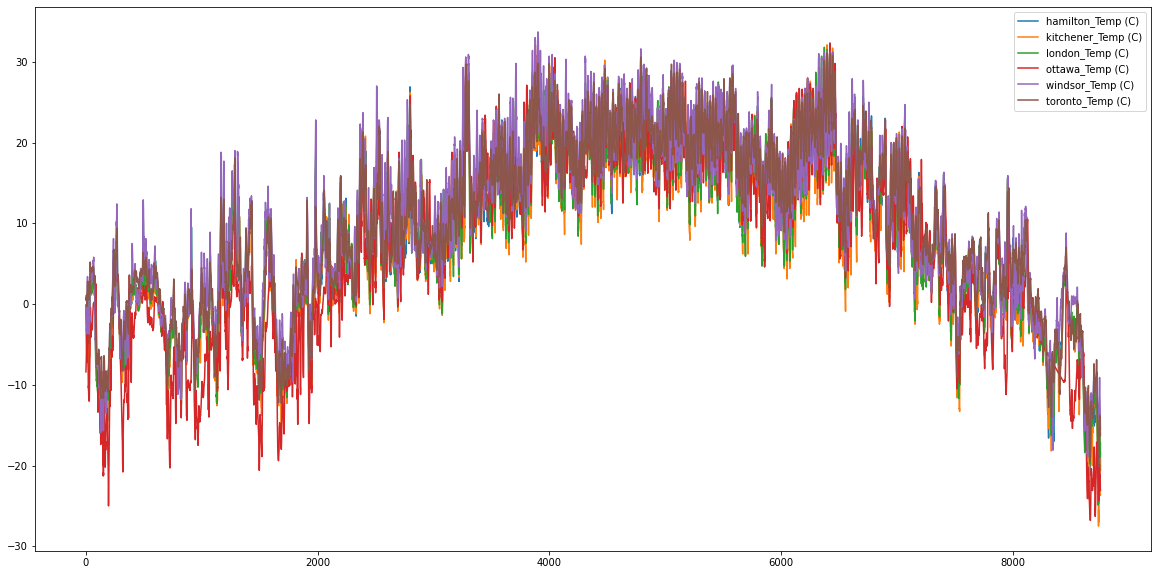

In [ ]:
df_2017.iloc[:, 4:].plot(figsize=(20,10))
plt.show()

**Daily average temperature vs time**

In [ ]:
# Daily average
df_daily_avg_2017 = df_2017.groupby(by=['Date']).mean()
df_daily_avg_2017

,Hour,Market Demand,Ontario Demand,hamilton_Temp (C),kitchener_Temp (C),london_Temp (C),ottawa_Temp (C),windsor_Temp (C),toronto_Temp (C)
Date,,,,,,,,,
2017-01-01,12.5,17034.416667,13947.333333,-1.329167,-3.070833,-1.679167,-6.566667,-0.870833,1.287500
2017-01-02,12.5,17842.708333,14781.625000,0.633333,-1.554167,-0.220833,-6.483333,0.941667,3.087500
2017-01-03,12.5,18639.291667,16201.666667,3.104167,1.825000,2.329167,-1.270833,4.116667,4.233333
2017-01-04,12.5,19250.916667,16343.541667,-3.054167,-4.137500,-4.466667,-1.191667,-3.458333,-1.187500
2017-01-05,12.5,20012.166667,17392.750000,-9.187500,-9.887500,-10.258333,-8.583333,-8.545833,-6.966667
...,...,...,...,...,...,...,...,...,...
2017-12-27,12.5,20342.791667,17272.916667,-16.425000,-16.900000,-15.300000,-22.245833,-14.833333,-13.266667
2017-12-28,12.5,21112.875000,17830.083333,-15.975000,-15.508333,-15.858333,-23.687500,-14.412500,-15.500000
2017-12-29,12.5,21092.875000,17531.083333,-12.975000,-13.516667,-12.570833,-20.904167,-10.075000,-11.350000


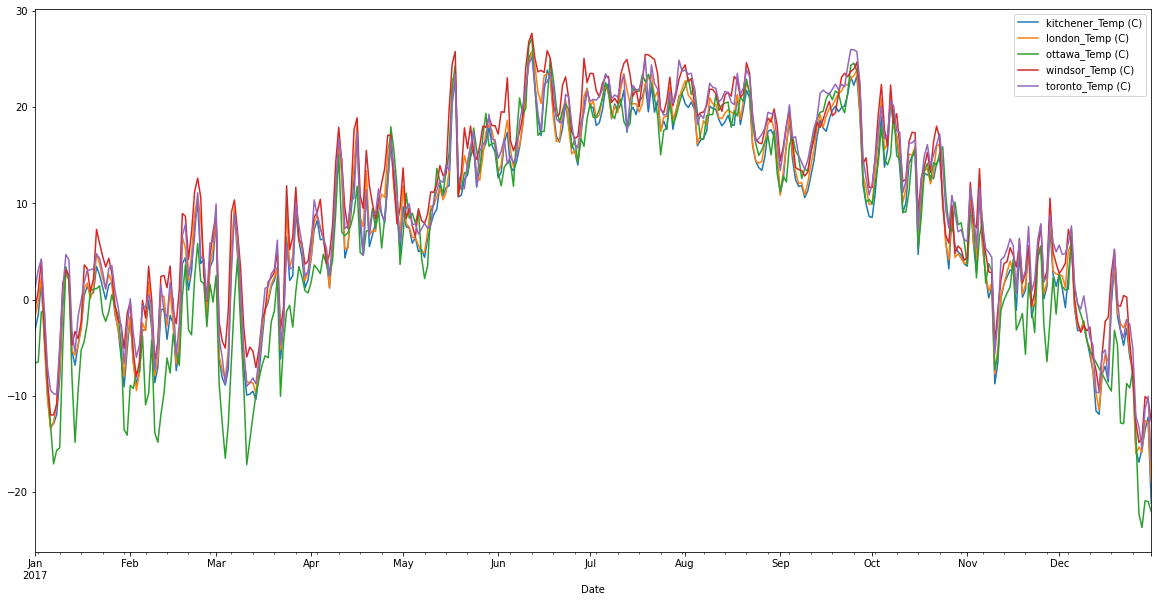

In [ ]:
df_daily_avg_2017.iloc[:, 4:].plot(figsize=(20,10))
plt.show()

Temperatures are very similar (Ottawa is slightly less than other cities)

**Electricity vs time**

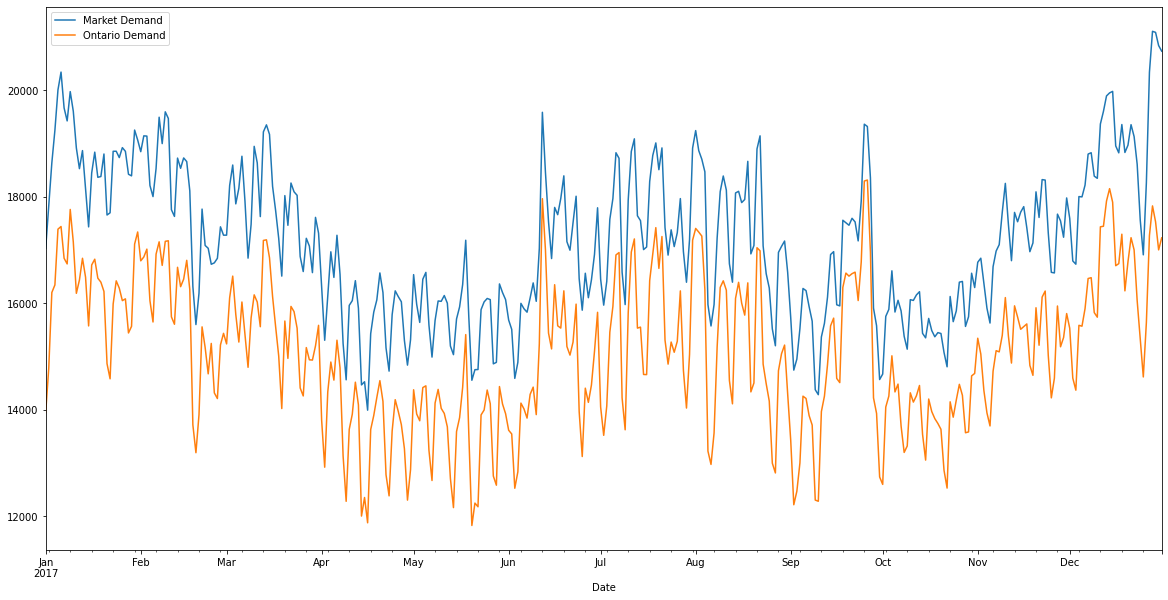

In [ ]:
# Daily average
df_daily_avg_2017.iloc[:, 1:3].plot(figsize=(20, 10))
plt.show()

**Electricity Demand vs Temperature**

In [ ]:
# Weighted average (population from 2015)
# Source: https://en.wikipedia.org/wiki/List_of_population_centres_in_Ontario
populations = {'toronto':5429524, 'ottawa':989567, 'hamilton': 693645, 'kitchener': 470015, 'london': 383437, 'windsor': 287069}
df['weighted_average_Temp (C)'] = (df['hamilton_Temp (C)'] * populations['hamilton'] + df['ottawa_Temp (C)'] * populations['ottawa'] \
                                + df['toronto_Temp (C)'] * populations['toronto'] + df['kitchener_Temp (C)'] * populations['kitchener'] \
                                + df['london_Temp (C)'] * populations['london'] + df['windsor_Temp (C)'] * populations['windsor'])/sum(populations.values())

In [ ]:
# Daily average
df_2017 = df[df['Date']<'2018-01-01']
df_daily_avg_2017 = df_2017.groupby(by=['Date']).mean()

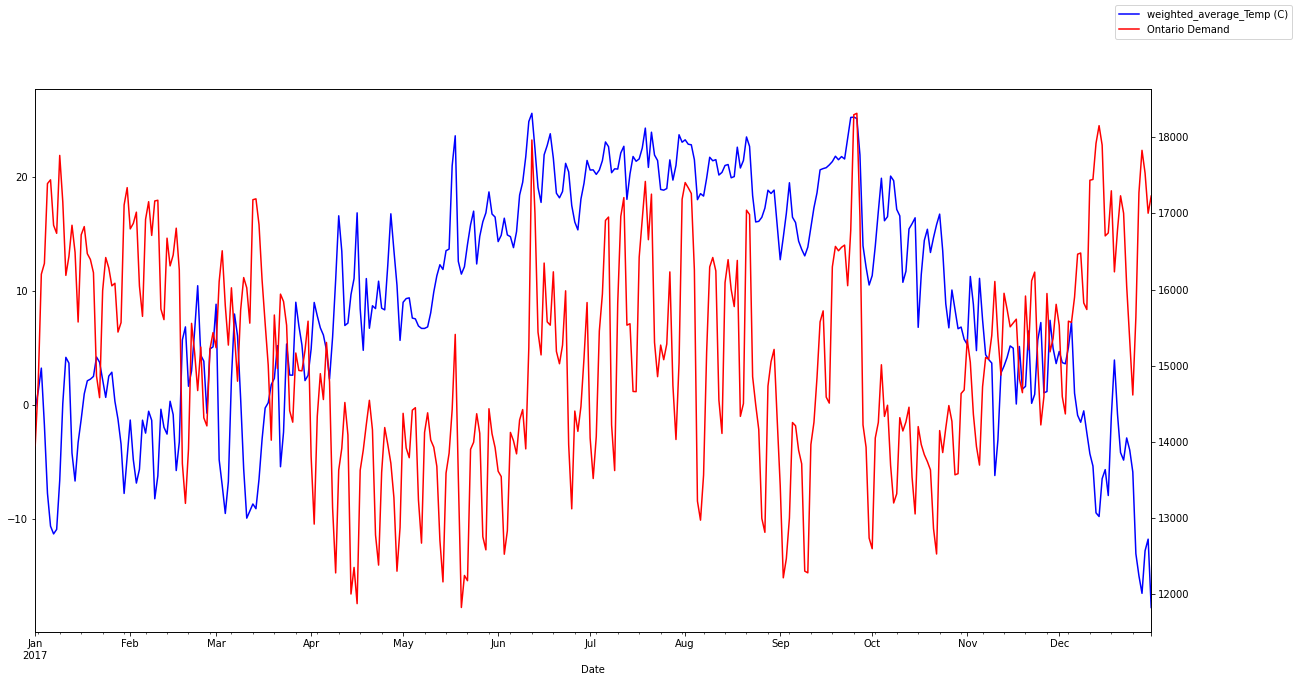

In [ ]:
fig, ax1 = plt.subplots(figsize=(20, 10))
ax2 = ax1.twinx()
df_daily_avg_2017['weighted_average_Temp (C)'].plot(ax=ax1, style='b-')
df_daily_avg_2017['Ontario Demand'].plot(ax=ax2, style='r-')
fig.legend()
plt.show()

Electricity demand increases when either temperature goes high or temperature goes low. 